<a href="https://colab.research.google.com/github/kilgorjn/CS_5300_AI/blob/main/CS_5300_Abalone_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Report 

## Downloading the data

In [4]:
import urllib.request
import os
import pandas as pd
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import timeit


if 'abalone.data' not in os.listdir():
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
if 'abalone.names' not in os.listdir():
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names


feature_names = ['Sex','Length','Diameter','Height','Whole Weight','Shucked Weight','Viscera Weight','Shell Weight']
target_name = 'Rings'
names = feature_names + [target_name]
df = pd.read_csv('abalone.data', names=names) 

#convert the 'Sex' feature from nomimal to numerical 
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes

#Convert the 'Rings' column to a binary 'Age', where 0 means 'young', and 1 means 'old'
df['Age'] = pd.DataFrame(np.where(df[target_name]<=9,0,1),columns=['Age'])
print(df.head())

#drop the 'Rings' feature, it is no longer needed
df.drop(labels='Rings', inplace=True, axis=1)
df.describe()  #un-normalized data


# for column in ['Length','Diameter','Height','Whole Weight','Shucked Weight','Viscera Weight','Shell Weight']:
#   df[column] = (df[column]-df[column].min())/(df[column].max()-df[column].min())
# df.describe()  #normalized data (all columns except Sex and Age)


   Sex  Length  Diameter  Height  ...  Viscera Weight  Shell Weight  Rings  Age
0    2   0.455     0.365   0.095  ...          0.1010         0.150     15    1
1    2   0.350     0.265   0.090  ...          0.0485         0.070      7    0
2    0   0.530     0.420   0.135  ...          0.1415         0.210      9    0
3    2   0.440     0.365   0.125  ...          0.1140         0.155     10    1
4    1   0.330     0.255   0.080  ...          0.0395         0.055      7    0

[5 rows x 10 columns]


,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.052909,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,0.498204
std,0.822240,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,0.500057
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,0.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,0.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,1.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,1.000000


# Visualize distributions of un-normalized data

As seen below, the features are not uniformly distributed.

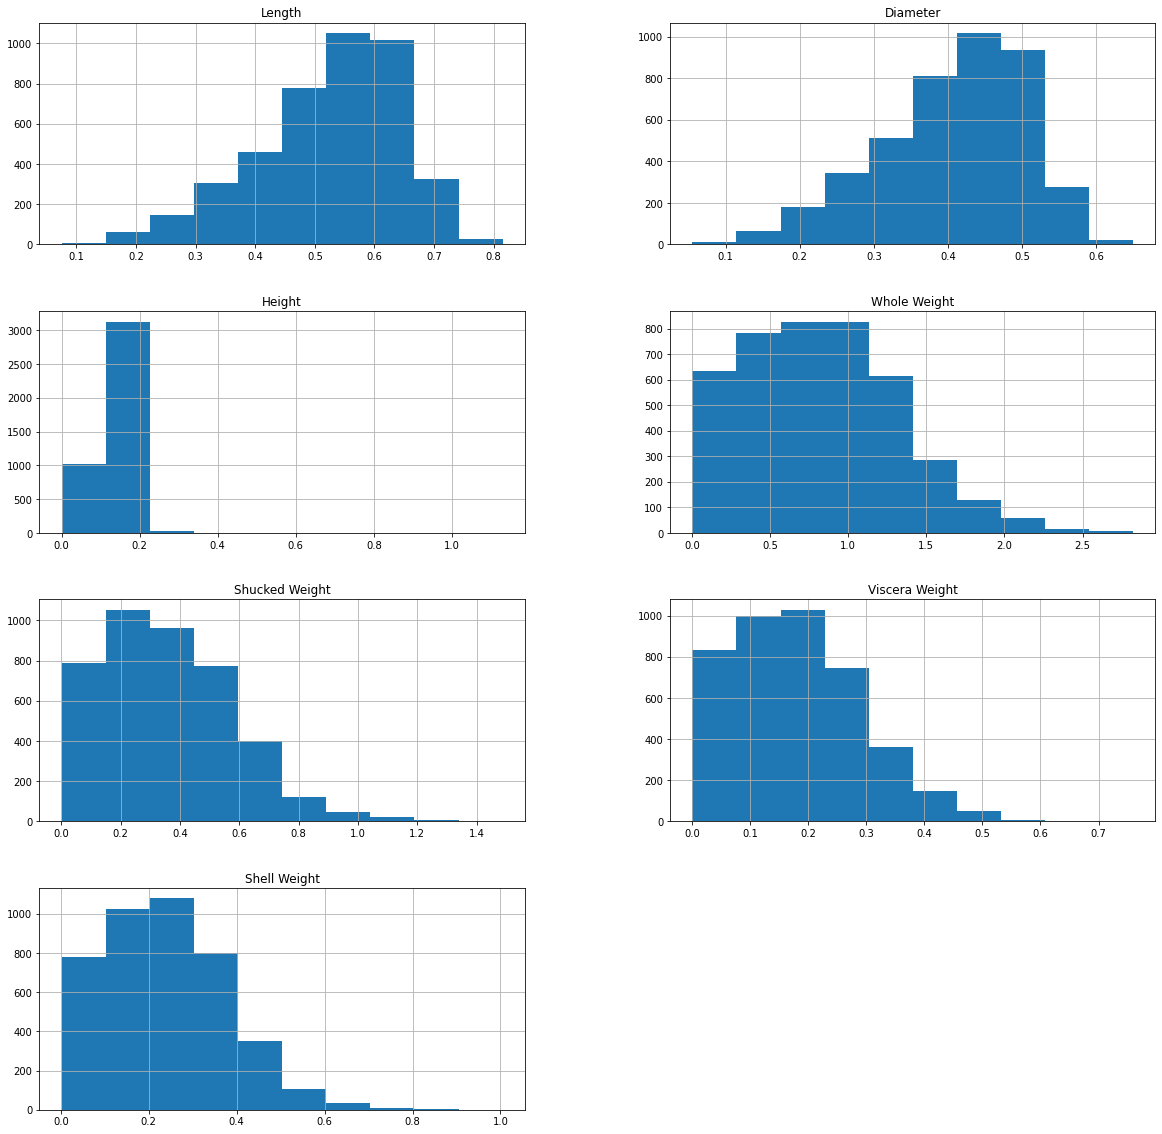

In [5]:
import matplotlib.pyplot as plt
# hist = df[['Length','Diameter','Height','Whole Weight','Shucked Weight','Viscera Weight','Shell Weight']].hist(figsize=(20,10), layout=(2,4))
hist = df.select_dtypes(include='float64').hist(figsize=(20,20), layout=(4,2))

# Normalize the feature data
## normalize each feature column to a range between 0 and 1. 

In [3]:
#normalize the data in-place
for column in ['Length','Diameter','Height','Whole Weight','Shucked Weight','Viscera Weight','Shell Weight']:
 df[column] = (df[column]-df[column].min())/(df[column].max()-df[column].min())
df.describe()  #normalized data (all columns except Sex and Age)
df.select_dtypes(include='float64').hist(figsize=(20,20), layout=(4,2))



,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.052909,0.606746,0.593078,0.123466,0.292808,0.241000,0.237121,0.236503,0.498204
std,0.822240,0.162288,0.166790,0.037015,0.173681,0.149269,0.144324,0.138717,0.500057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.506757,0.495798,0.101770,0.155658,0.124412,0.122449,0.128052,0.000000
50%,1.000000,0.635135,0.621849,0.123894,0.282451,0.225286,0.224490,0.231689,0.000000
75%,2.000000,0.729730,0.714286,0.146018,0.407650,0.336920,0.332456,0.326358,1.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.to_csv('normalized.csv')

# Split the data into training, validation,  and test sets

In [14]:
np.random.seed(0)  #set a seed to reproduce train and test sets over multiple runs
# msk = np.random.rand(len(df)) < 0.8

print('before shuffle')
print(df.head())
df = df.sample(frac=1, axis=0).reset_index(drop=True)
print('after shuffle')
print(df.head())


train_size = round(df.shape[0]*.7)
val_size = round(df.shape[0]*.2)
test_size = round(df.shape[0]*.1)

print(f'train_size = {train_size}:  val_size = {val_size}  test_size={test_size}')

df_x_train = df[0:train_size]
df_y_train = df_x_train['Age']
df_x_train = df_x_train.drop('Age', axis=1)

df_x_val = df[train_size:train_size+val_size]
df_y_val = df_x_val['Age']
df_x_val = df_x_val.drop('Age', axis=1)


df_x_test = df[train_size+val_size:train_size+val_size+test_size]
df_y_test = df_x_test['Age']
df_x_test = df_x_test.drop('Age', axis=1)


print(f'df shape: {df.shape}')
print(f'training shape(X): {df_x_train.shape}')
print(f'training shape(Y): {df_y_train.shape}')

print(f'validation shape(X): {df_x_val.shape}')
print(f'validation shape(Y): {df_y_val.shape}')


print(f'testing shape(X): {df_x_test.shape}')
print(f'testing shape(Y): {df_y_test.shape}')

print(df_x_train.head())
print(df_x_val.head())
print(df_x_test.head())


before shuffle
   Sex  Length  Diameter  ...  Viscera Weight  Shell Weight  Age
0    2   0.455     0.365  ...          0.1010         0.150    1
1    2   0.350     0.265  ...          0.0485         0.070    0
2    0   0.530     0.420  ...          0.1415         0.210    0
3    2   0.440     0.365  ...          0.1140         0.155    1
4    1   0.330     0.255  ...          0.0395         0.055    0

[5 rows x 9 columns]
after shuffle
   Sex  Length  Diameter  ...  Viscera Weight  Shell Weight  Age
0    2   0.550     0.425  ...          0.2430        0.3350    1
1    1   0.500     0.400  ...          0.1430        0.1935    0
2    2   0.620     0.480  ...          0.3740        0.3175    1
3    1   0.220     0.165  ...          0.0120        0.0200    0
4    2   0.645     0.500  ...          0.3755        0.3775    1

[5 rows x 9 columns]
train_size = 2924:  val_size = 835  test_size=418
df shape: (4177, 9)
training shape(X): (2924, 8)
training shape(Y): (2924,)
validation shape(X): 

#  Create Utility Functions
This cell just has utility functions for use evaluating different architectures

In [18]:




METRICS = [
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      # # keras.metrics.Precision(name='precision'),
      # keras.metrics.Recall(name='recall'),
      # keras.metrics.AUC(name='auc'),
]

###########################################################
# Build a model based on the provided architecture
###########################################################
def build_model(architecture:[], hidden_activation='relu', output_activation='sigmoid'):
  model = Sequential()
  model.add(Input(shape=df_x_train.shape[1]))
  # the architecture is a list of node_counts.  
  # Create a hidden layer w/ the specified 
  # number of nodes for each layer in the architecture.
  for nodes in architecture:
    model.add(Dense(nodes, activation=hidden_activation))  
  model.add(Dense(1, activation=output_activation))

  model.compile(
      optimizer=keras.optimizers.RMSprop(),
      loss = keras.losses.BinaryCrossentropy(),
      metrics = METRICS
      )
  return model





#########################################
# Function to train a model and return the training history.
# batch_size and epochs have defaults, but can be overridden
#########################################
def train_model(model, train_x, train_y, val_x, val_y, identifier, batch_size=64, epochs=256, use_early_stop=False):
  # print('--------Training model: ')
  # print(model.summary())
  print(f'training model {identifier}')

  callback_earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
  callbacks = []
  if use_early_stop:
    callbacks.append(callback_earlystop)

  return model.fit(x=train_x, 
                    y=train_y, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(val_x, val_y),
                    verbose=0,
                    callbacks=callbacks
                    )

def evaluate_model(model:tf.keras.Model, x_data, y_data):
  return model.evaluate(x_data, y_data, batch_size=128)
  


# Visualize the output labels
## The output labels ('Rings') indicate the age (in years) of the abalone, and is a numerical value between 1 and 29.  The data that we have indicates the average age is 9.9 years old.

In order to convert this to a binary classification problem, we will convert this range into 2 values, 'Young' and 'Old'. 

The median number of Rings in the dataset is 9, so we will use this value as the cutoff to divide the data into 'Young' == 0  (Rings <=9) or 'Old' == 1 (Rings > 9)

count    4177.000000
mean        0.498204
std         0.500057
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Age, dtype: float64


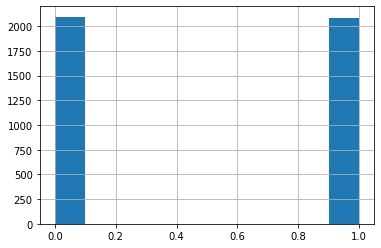

In [12]:
import numpy as np
# df_labels = df[target_name]
df['Age'].hist()
print(df['Age'].describe())
df_labels = pd.DataFrame(columns=['Age'])
# df_labels.head()
# df_labels.describe()

# Logistic Regression on validation data

In [15]:
log_model = Sequential()
log_model.add(Dense(1, input_dim = df_x_val.shape[1], activation='sigmoid'))
log_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
log_model.fit(df_x_train, df_y_train, epochs=256, verbose = 0)

log_prediction = np.round(log_model.predict(df_x_val)).ravel().astype(int)

log_accuracy = (np.count_nonzero(df_y_val.to_numpy() == log_prediction))/df_y_val.shape[0]
print(f'Accuracy of Logistic Regression is {log_accuracy}')

Accuracy of Logistic Regression is 0.7353293413173653


# Create a Neural Network

In [16]:
s4_model = Sequential()
s4_model.add(Input(shape=df_x_val.shape[1]))
s4_model.add(Dense(1, activation='relu'))
s4_model.add(Dense(1, activation='sigmoid'))
s4_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
s4_model.fit(df_x_train, df_y_train, epochs=256, verbose = 0)

s4_prediction = np.round(s4_model.predict(df_x_val)).ravel().astype(int)

s4_accuracy = (np.count_nonzero(df_y_val.to_numpy() == s4_prediction))/df_y_val.shape[0]
print(f'Accuracy of Neural Network is {s4_accuracy}')

Accuracy of Neural Network is 0.7568862275449102


# Experiment with various numbers of layers
This cell evaluates different model architectures.  
Different architectures/lists are stored in the 'architectures' list.  
Then, a model is built for each architecture; each model is trained, then the least complex model with the highest accuracy will be chosen as the baseline model.

training model [50, 50]
{'loss': [0.6236652135848999, 0.5677787065505981, 0.5372545123100281, 0.5227757692337036, 0.5134894251823425, 0.5056769251823425, 0.49742504954338074, 0.4902682602405548, 0.4860006868839264, 0.48090216517448425, 0.4756280183792114, 0.4720729887485504, 0.4678843915462494, 0.46385011076927185, 0.4603985846042633, 0.4574321210384369, 0.45284485816955566, 0.44930580258369446, 0.446504145860672, 0.4438863694667816, 0.44127967953681946, 0.44068342447280884, 0.43839552998542786, 0.4359336793422699, 0.43402180075645447, 0.4331924617290497, 0.4323894679546356, 0.4299887418746948, 0.42808640003204346, 0.4268474578857422, 0.42893049120903015, 0.42616745829582214, 0.42738011479377747, 0.4237740635871887, 0.42621925473213196, 0.42635414004325867, 0.42421388626098633, 0.425533652305603, 0.42273998260498047, 0.4246886372566223, 0.42375481128692627, 0.4234253466129303, 0.4246244728565216, 0.4221818447113037, 0.4224465787410736, 0.42143285274505615, 0.42059335112571716, 0.421582

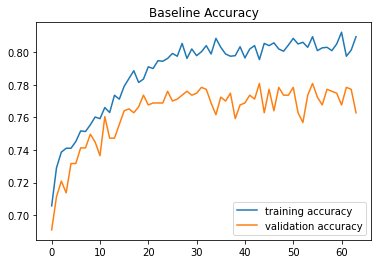

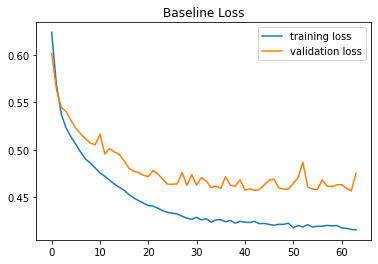

In [21]:
def eval_different_model_archs():
  #Create different types of model architectures.

  

  
  architectures = [
                   [10 for _ in range(1)],
                   [20 for _ in range(1)],
                   [50 for _ in range(1)],
                   [100 for _ in range(1)],
                   [200 for _ in range(1)],
                   [1000 for _ in range(1)],

                   [10 for _ in range(2)],
                   [20 for _ in range(2)],
                   [50 for _ in range(2)],
                   [100 for _ in range(2)],
                   [200 for _ in range(2)],                   
                   [1000 for _ in range(2)],

                   [10 for _ in range(3)],
                   [20 for _ in range(3)],
                   [50 for _ in range(3)],
                   [100 for _ in range(3)],
                   [200 for _ in range(3)],
                   [1000 for _ in range(3)],
                   
                   [10 for _ in range(4)],
                   [20 for _ in range(4)],
                   [50 for _ in range(4)],
                   [100 for _ in range(4)],
                   [200 for _ in range(4)],
                   [1000 for _ in range(4)],

                   [10 for _ in range(5)],
                   [20 for _ in range(5)],
                   [50 for _ in range(5)],
                   [100 for _ in range(5)],
                   [200 for _ in range(5)],
                   [1000 for _ in range(5)],
                  ]

  # Build a model per architecture                 
  print('building the models')
  models = [build_model(n) for n in architectures]

  # Train each model
  print('training the models')
  histories = [ train_model(model, df_x_train, df_y_train, df_x_val, df_y_val,architectures[i],epochs=64) for i,model in enumerate(models)]


  print('------histories-----')
  print(histories)
  for history in histories:
    print(history.history)

  print('-----')
  for i, history in enumerate(histories):
    print(f'{i}: {max(history.history["val_accuracy"])} {architectures[i]}')


  print('evaluating the models')
  evaluations = [ model.evaluate(df_x_test, df_y_test, batch_size=128) for model in models]

  for i, evaluation in enumerate(evaluations):
    print(f'{i} evaluation = {evaluation} history = {max(histories[i].history["val_accuracy"])} architecture = {architectures[i]}')



# The best architecture is a model with 2 hidden layers, each layer containing 50 nodes.
def eval_chosen_model():
  chosen_arch = [50,50]
  chosen_model = build_model(chosen_arch)
  history =   train_model(chosen_model, df_x_train, df_y_train, df_x_val, df_y_val,chosen_arch,epochs=64) 
  print(history.history)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['training accuracy','validation accuracy'])
  plt.title('Baseline Accuracy')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['training loss','validation loss'])
  plt.title('Baseline Loss')
  plt.show()
  return chosen_model

chosen_model = eval_chosen_model()

## Test Data on Selected Model

[0.         0.         0.         0.0047619  0.0047619  0.00952381
 0.00952381 0.01428571 0.01428571 0.01904762 0.01904762 0.02380952
 0.02380952 0.02857143 0.02857143 0.03809524 0.03809524 0.04285714
 0.04285714 0.04761905 0.04761905 0.05238095 0.05238095 0.06190476
 0.06190476 0.07142857 0.07142857 0.07619048 0.07619048 0.08571429
 0.08571429 0.09047619 0.09047619 0.1047619  0.1047619  0.11428571
 0.11428571 0.12857143 0.12857143 0.13333333 0.13333333 0.13809524
 0.13809524 0.14285714 0.14285714 0.15714286 0.15714286 0.16190476
 0.16190476 0.17142857 0.17142857 0.17619048 0.17619048 0.18571429
 0.18571429 0.19047619 0.19047619 0.1952381  0.1952381  0.21904762
 0.21904762 0.23809524 0.23809524 0.24285714 0.24285714 0.24761905
 0.24761905 0.25238095 0.25238095 0.25714286 0.25714286 0.26190476
 0.26190476 0.26666667 0.26666667 0.27142857 0.27142857 0.27619048
 0.27619048 0.28095238 0.28095238 0.29047619 0.29047619 0.2952381
 0.2952381  0.31428571 0.31428571 0.31904762 0.31904762 0.33809

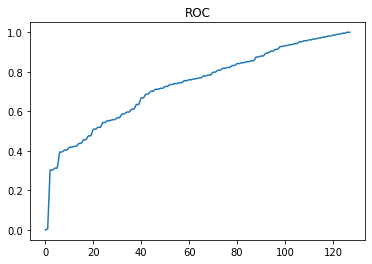

In [22]:
from sklearn.metrics import roc_curve,auc

 
#  predictions = chosen_model.evaluate(df_x_test, df_y_test, batch_size=128)
#  print(chosen_model.metrics_names)


y_pred_keras = chosen_model.predict(df_x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(df_y_test, y_pred_keras)

print(fpr_keras)
plt.plot(tpr_keras)
plt.title("ROC")
plt.show()

# Changing activation function of output layer to 'relu'

training model [50, 50]


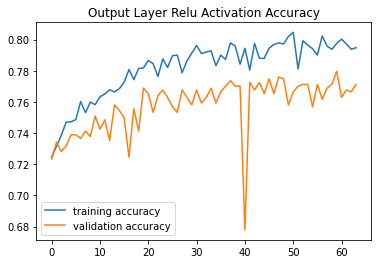

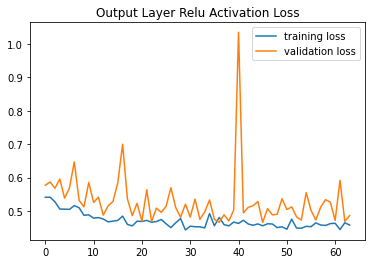

In [23]:
relu_output_model = build_model([50,50], output_activation='relu')
history =   train_model(relu_output_model, df_x_train, df_y_train, df_x_val, df_y_val,[50,50],epochs=64) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy','validation accuracy'])
plt.title('Output Layer Relu Activation Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Output Layer Relu Activation Loss')
plt.show()


# Changing activation function of output layer to 'linear'

training model [50, 50]


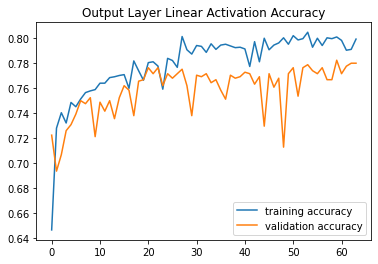

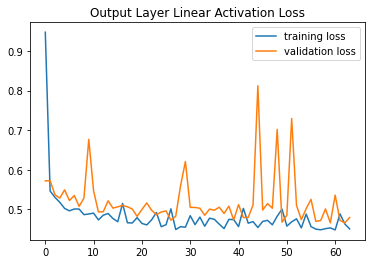

In [24]:
linear_output_model = build_model([50,50], output_activation='linear')
history =   train_model(linear_output_model, df_x_train, df_y_train, df_x_val, df_y_val,[50,50],epochs=64) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy','validation accuracy'])
plt.title('Output Layer Linear Activation Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Output Layer Linear Activation Loss')
plt.show()

# Overfitting the data

training model [50, 50, 50, 50]


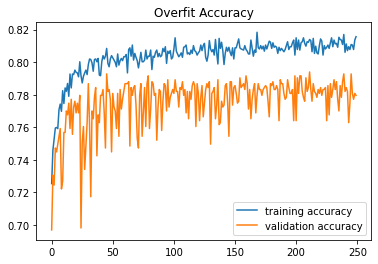

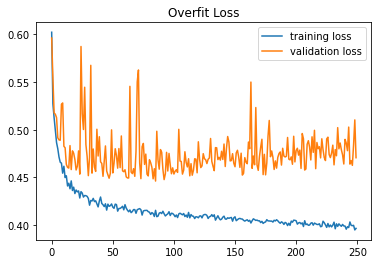

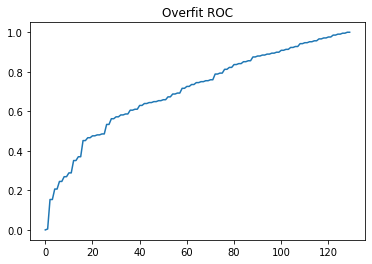

0.8763507326007325


In [30]:
def overfit_the_data(epochs):
  overfit_model = build_model([50,50,50,50])
  history =   train_model(overfit_model, df_x_train, df_y_train, df_x_val, df_y_val,[50,50,50,50],epochs=epochs) 



  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['training accuracy','validation accuracy'])
  plt.title('Overfit Accuracy')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['training loss','validation loss'])
  plt.title('Overfit Loss')
  plt.show()

  y_pred_overfit = overfit_model.predict(df_x_test).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(df_y_test, y_pred_overfit)

  plt.plot(tpr_keras)
  plt.title("Overfit ROC")
  plt.show()

  auc_var = auc(fpr_keras, tpr_keras)
  print(auc_var)

overfit_the_data(250)

# Grad Only:  Code a function that represents your model

In [27]:
def code_a_func():
  model = build_model([50,50])
  train_model(model, df_x_train, df_y_train, df_x_val, df_y_val,[50,50],epochs=64)

  # use the keras model to predict the outcomes.  
  # Round the output to create a binary classifier
  predictions = np.round(model.predict(df_x_test))

  def relu(_x):
      return np.maximum(_x, 0)

  def sigmoid(_x):
      return 1/(1+np.exp(-_x))

  my_model = [
      {'weights':layer.get_weights()[0], 
      'bias':layer.get_weights()[1],
      'activation':layer.get_config()['activation']
      } for layer in model.layers]

  def my_predict(_input, _model):
    _a = _input
    _activations = {'relu':relu,'sigmoid':sigmoid}

    for layer in _model:
      _a = _activations[layer['activation']](np.dot(_a,layer['weights'])+layer['bias'])

    return _a

  # use my_predict function to predict the outcomes.  
  # Round the output to create a binary classifier
  my_predictions = np.round(my_predict(df_x_test, my_model))

  print('are predictions equal?: ',(predictions == my_predictions).all())    

code_a_func()

training model [50, 50]
are predictions equal?:  True


# Phase III



## Recursive Feature Elimination

In [ ]:
def recursive_feature_elimination():
  print(feature_names)
  for feature in feature_names:
    print(feature)
    val_accuracies = {}
    accuracies = {}
    # create new train and validation dataframes with only a single feature
    df_rde_x_train = df_x_train[feature].to_numpy()
    df_rde_x_val = df_x_val[feature].to_numpy()

    print(df_rde_x_train.shape)
  
    model = Sequential()
    model.add(Input(shape=1))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
      optimizer=keras.optimizers.RMSprop(),
      loss = keras.losses.BinaryCrossentropy(),
      metrics = METRICS)    

    history = model.fit(x=df_rde_x_train, 
      y=df_y_train, 
      batch_size=64, 
      epochs=64, 
      validation_data=(df_rde_x_val, df_y_val),
      verbose=0,
      callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)])
    val_accuracies[feature]=history.history['val_accuracy'][-1]
    accuracies[feature]=history.history['accuracy'][-1]
    print(feature,',',history.history['val_accuracy'][-1],',',history.history['accuracy'][-1])
  return (val_accuracies, accuracies)



(val_accuracies, accuracies) = recursive_feature_elimination()
print(val_accuracies)
print(accuracies)

['Sex', 'Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
Sex
(2924,)
Epoch 00030: early stopping
Sex , 0.6898203492164612 , 0.7058823704719543
Length
(2924,)
Epoch 00037: early stopping
Length , 0.6970059871673584 , 0.7250341773033142
Diameter
(2924,)
Epoch 00055: early stopping
Diameter , 0.7101796269416809 , 0.7308481335639954
Height
(2924,)
Epoch 00020: early stopping
Height , 0.7209580540657043 , 0.7482900023460388
Whole Weight
(2924,)
Epoch 00032: early stopping
Whole Weight , 0.7101796269416809 , 0.7322161197662354
Shucked Weight
(2924,)
Shucked Weight , 0.682634711265564 , 0.6925444602966309
Viscera Weight
(2924,)
Epoch 00031: early stopping
Viscera Weight , 0.71257483959198 , 0.7393980622291565
Shell Weight
(2924,)
Epoch 00046: early stopping
Shell Weight , 0.7341317534446716 , 0.7609438896179199
{'Shell Weight': 0.7341317534446716}
{'Shell Weight': 0.7609438896179199}


From the data above, the features have been sorted by validation accuracy (small to large).  The sorted features are: 
'Shucked Weight' ,'Sex' ,'Length' ,'Viscera Weight' ,'Whole Weight' ,'Diameter' ,'Height' ,'Shell Weight'

# Iteratively remove 1 feature at a time

In [ ]:



features_sorted_small_to_large = ['Shucked Weight' ,'Sex' ,'Length' ,'Viscera Weight' ,'Whole Weight' ,'Diameter' ,'Height' ,'Shell Weight']

print(df_x_train.head())

df_rm_x_train = df_x_train.copy()
df_rm_x_train = df_rm_x_train[features_sorted_small_to_large]

df_rm_x_val = df_x_val.copy()
df_rm_x_val = df_rm_x_val[features_sorted_small_to_large]

# 
print(df_rm_x_train.head())

feature_removed = None
for feature in features_sorted_small_to_large:

  
  model = Sequential()
  model.add(Input(shape=df_rm_x_train.shape[1]))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = METRICS)    

  history = model.fit(x=df_rm_x_train, 
    y=df_y_train, 
    batch_size=64, 
    epochs=64, 
    validation_data=(df_rm_x_val, df_y_val),
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)])

  print(df_rm_x_train.columns.values)
  print(f'After removing {feature_removed}',',',history.history['val_accuracy'][-1],',',history.history['accuracy'][-1])

  df_rm_x_train.drop([feature], axis=1, inplace=True)
  df_rm_x_val.drop([feature], axis=1, inplace=True)
  feature_removed = feature

# print(df_rm_x_train.head())
# print(df_x_val.head())






   Sex    Length  Diameter  ...  Shucked Weight  Viscera Weight  Shell Weight
0    2  0.641892  0.621849  ...        0.185945        0.319289      0.332337
1    1  0.574324  0.579832  ...        0.174849        0.187623      0.191330
2    2  0.736486  0.714286  ...        0.353732        0.491771      0.314898
3    1  0.195946  0.184874  ...        0.013786        0.015142      0.018435
4    2  0.770270  0.747899  ...        0.452253        0.493746      0.374689

[5 rows x 8 columns]
   Shucked Weight  Sex    Length  ...  Diameter    Height  Shell Weight
0        0.185945    2  0.641892  ...  0.621849  0.137168      0.332337
1        0.174849    1  0.574324  ...  0.579832  0.106195      0.191330
2        0.353732    2  0.736486  ...  0.714286  0.137168      0.314898
3        0.013786    1  0.195946  ...  0.184874  0.048673      0.018435
4        0.452253    2  0.770270  ...  0.747899  0.154867      0.374689

[5 rows x 8 columns]
Epoch 00060: early stopping
['Shucked Weight' 'Sex' 'Len

# Remove the 'Length' feature and compare

In [ ]:
#Remove just the 'length' feature and compare the all features.

features_sorted_small_to_large = ['Shucked Weight' ,'Sex' ,'Length' ,'Viscera Weight' ,'Whole Weight' ,'Diameter' ,'Height' ,'Shell Weight']
features_to_remove = ['Length']

print(df_x_train.head())

df_rm_x_train = df_x_train.copy()
df_rm_x_train = df_rm_x_train[features_sorted_small_to_large]

df_rm_x_val = df_x_val.copy()
df_rm_x_val = df_rm_x_val[features_sorted_small_to_large]

# 
print(df_rm_x_train.head())

model = Sequential()
model.add(Input(shape=df_rm_x_train.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
  optimizer=keras.optimizers.RMSprop(),
  loss = keras.losses.BinaryCrossentropy(),
  metrics = METRICS)    

history = model.fit(x=df_rm_x_train, 
  y=df_y_train, 
  batch_size=64, 
  epochs=64, 
  validation_data=(df_rm_x_val, df_y_val),
  verbose=1,
  callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)])



#drop the Length feature and retrain


df_rm_x_train.drop(['Length'], axis=1, inplace=True)
df_rm_x_val.drop(['Length'], axis=1, inplace=True)


model = Sequential()
model.add(Input(shape=df_rm_x_train.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
  optimizer=keras.optimizers.RMSprop(),
  loss = keras.losses.BinaryCrossentropy(),
  metrics = METRICS)    

history = model.fit(x=df_rm_x_train, 
  y=df_y_train, 
  batch_size=64, 
  epochs=64, 
  validation_data=(df_rm_x_val, df_y_val),
  verbose=1,
  callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)])







   Sex    Length  Diameter  ...  Shucked Weight  Viscera Weight  Shell Weight
0    2  0.641892  0.621849  ...        0.185945        0.319289      0.332337
1    1  0.574324  0.579832  ...        0.174849        0.187623      0.191330
2    2  0.736486  0.714286  ...        0.353732        0.491771      0.314898
3    1  0.195946  0.184874  ...        0.013786        0.015142      0.018435
4    2  0.770270  0.747899  ...        0.452253        0.493746      0.374689

[5 rows x 8 columns]
   Shucked Weight  Sex    Length  ...  Diameter    Height  Shell Weight
0        0.185945    2  0.641892  ...  0.621849  0.137168      0.332337
1        0.174849    1  0.574324  ...  0.579832  0.106195      0.191330
2        0.353732    2  0.736486  ...  0.714286  0.137168      0.314898
3        0.013786    1  0.195946  ...  0.184874  0.048673      0.018435
4        0.452253    2  0.770270  ...  0.747899  0.154867      0.374689

[5 rows x 8 columns]
Epoch 1/64
46/46 [==============================] - 1s 6